 # Benzamidine binding to Trypsin

In [1]:
import pyemma
pyemma.__version__

'1.2.2-147-g7de055b-dirty'

This notebook has been tested for version 1.2.1. If you are using a different version some adaptations may be required.
Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


Now we import the PyEMMA modules required later.

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl
from pyemma import config

In [4]:
def save_figure(name):
    # change these if wanted
    do_save = True
    fig_dir = './figs/'
    if do_save:
        savefig(fig_dir + name, bbox_inches='tight')

## Trypsin/Benzamidine - load data

In [5]:
indir = './data'
topfile =  indir+'/tryp_ben_protein.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('-200ns.xtc'):
        traj_list.append(os.path.join(indir,filename))

We can decide here which coordinates we would like to use in the further analysis.

In [6]:
feat = coor.featurizer(topfile)
n_res = 223 # number of residues
ben_ind = 225 # benzamidine index (with residues starting at 1)
ind_arr = np.zeros((n_res,2))
for i in range(n_res):
    ind_arr[i][0] = ben_ind-1
    ind_arr[i][1] = i
feat.add_residue_mindist(residue_pairs=(ind_arr), scheme='closest-heavy', ignore_nonprotein=False, threshold=0.5)
#feat.describe()

In [7]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0),' ns'
print 'total data = ',inp.number_of_trajectories()*inp.trajectory_length(0),' ns'
print 'number of dimension = ',inp.dimension()

number of trajectories =  50
trajectory length =  200  ns
total data =  10000  ns
number of dimension =  223


We would also like to know the total number of contacts for each frame to analyze the binding.

In [8]:
contact_trajs = inp.get_output()

In [9]:
ct = np.array(contact_trajs)
contact_array = np.zeros((inp.number_of_trajectories(),inp.trajectory_length(0)))
for i in range(inp.number_of_trajectories()):
    for j in range(inp.trajectory_length(0)):
        contact_array[i][j] = sum(contact_trajs[i][j])

In [10]:
# remove constant - just to see if it makes a numerical difference
maxdifference = np.zeros(inp.dimension())
for ct in contact_trajs:
    diff = np.max(ct, axis=0) - np.min(ct, axis=0)
    maxdifference = np.maximum(maxdifference, diff)
# select nonconstant
Inc = np.where(maxdifference > 0.001)[0]
# rewrite trajectory to nonconstant
var_contact_trajs = [ct[:, Inc] for ct in contact_trajs]

## TICA and clustering

In [11]:
tica_lag = 10      # tica lagtime

In [12]:
tica_obj = coor.tica(var_contact_trajs, lag=tica_lag, kinetic_map=True, var_cutoff=0.95)#, dim=tica_dim)

59


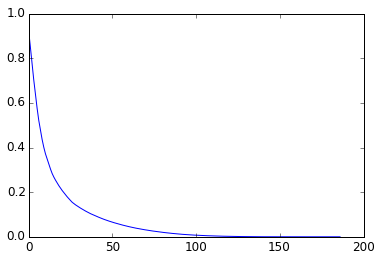

In [13]:
print tica_obj.dimension()
cum_variance = tica_obj.cumvar
plot(1-cum_variance)

In [14]:
Y = tica_obj.get_output() # get tica coordinates

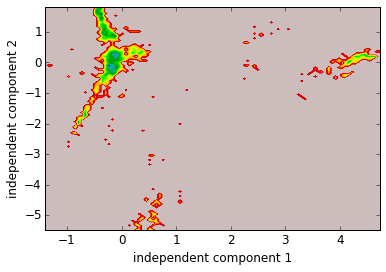

In [15]:
mpl.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], cbar=False)
xlabel('independent component 1')
ylabel('independent component 2')
save_figure('free_energy.png')

### Clustering

In [16]:
n_clusters = 200      # number of k-means clusters
cl_metric = 'euclidean' # clustering metric

In [17]:
clustering = coor.cluster_kmeans(Y,k=n_clusters,max_iter=1000)

2015-08-04 18:53:28,623 coordinates.clustering.KmeansClustering[3] INFO     Cluster centers converged after 8 steps.


In [18]:
dtrajs = coor.assign_to_centers(Y, centers=clustering.clustercenters, stride=1, return_dtrajs=True, metric=cl_metric)

In order to analyze the distribution of the data to the cluster centers we make a histogram of the discrete trajectories.

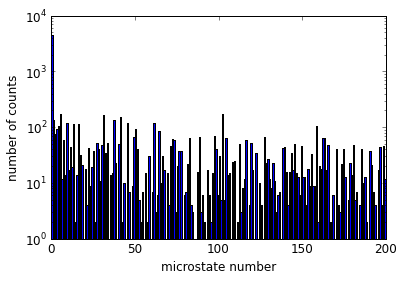

In [19]:
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
ind = np.arange(len(histogram))
plt.bar(ind, histogram, log=True)
plt.xlabel('microstate number')
plt.ylabel('number of counts')

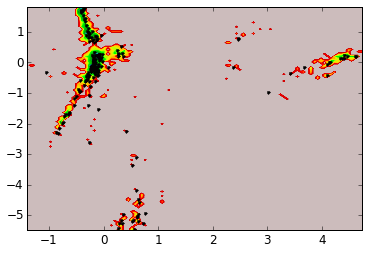

In [20]:
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
mpl.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], cbar=False)
plot(cc_x,cc_y, linewidth=0, marker='.', color='black')

In [21]:
# analyze microstate distribution as a function of total number of contacts
nstates = len(clustering.clustercenters)
statecount = [0 for n in range(nstates)]
statedist = [0.0 for n in range(nstates)]
for i in range(len(dtrajs)):
    for j in range(len(dtrajs[i])):
        state = dtrajs[i][j]
        dist = contact_array[i][j]
        statecount[state] += 1
        statedist[state] += float(dist) 
distogram = np.zeros((nstates))
for i in range(nstates):
    distogram[i] = float(statedist[i])/float(statecount[i])

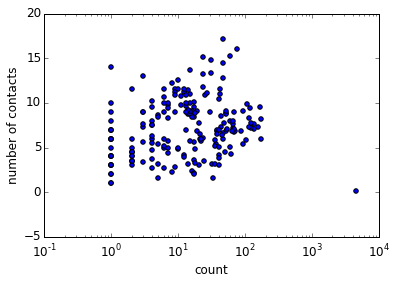

In [22]:
# did we resolve bound and unbound state?
scatter(histogram,distogram)
semilogx(); xlabel('count')
ylabel('number of contacts')

# Implied timescales

In [23]:
bits = msm.timescales_msm(dtrajs, lags=50, nits=5, errors='bayes')

(0, 40)

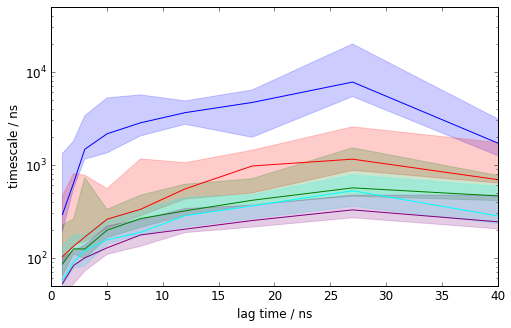

In [24]:
figure(figsize(8, 5))
mpl.plot_implied_timescales(bits, show_mean=False, ylog=True, units='ns')
save_figure('its.png')
ylim(50,50000)
xlim(0, 40)

# Estimate MSM

In [84]:
M = msm.bayesian_markov_model(dtrajs, 25)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  0.97
fraction of counts used =  0.9985


(-0.5, 10.5)

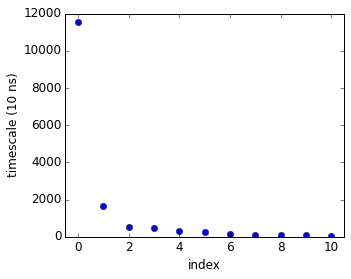

In [85]:
figure(figsize(5, 4))
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ns)'); xlim(-0.5,10.5)

(0.6, 1.05)

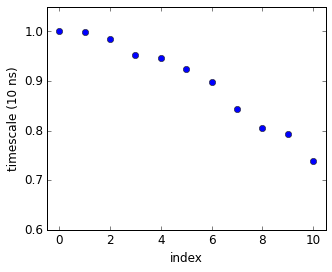

In [86]:
figure(figsize(5, 4))
plot(M.eigenvalues(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ns)'); xlim(-0.5,10.5) ;ylim(0.6,1.05)

In [88]:
# validate
cktest = M.cktest(5, mlags=5)

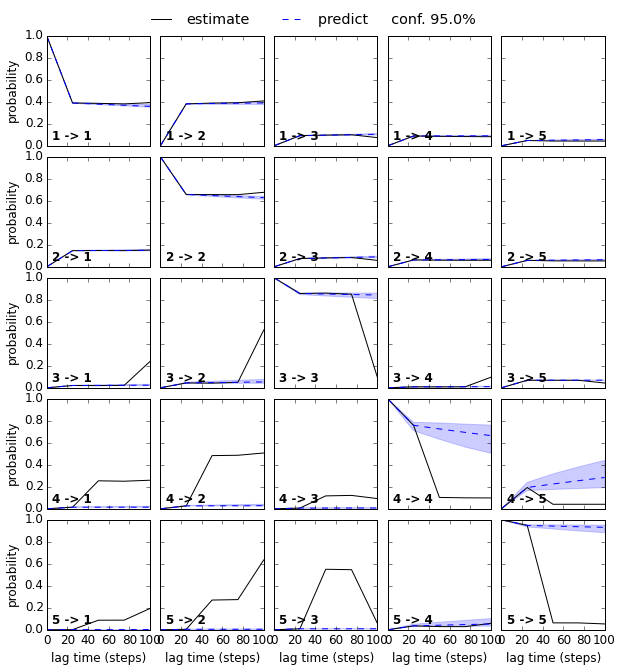

In [89]:
mpl.plot_cktest(cktest, padding_top=0.05)
save_figure('cktest.png')

In [90]:
pi = M.stationary_distribution # stationary distribution
F_pi = -np.log(pi)  # free energy based on stationary distribution

In [91]:
connected = M.connected_sets[0]
c_cc_x = cc_x[connected]
c_cc_y = cc_y[connected]

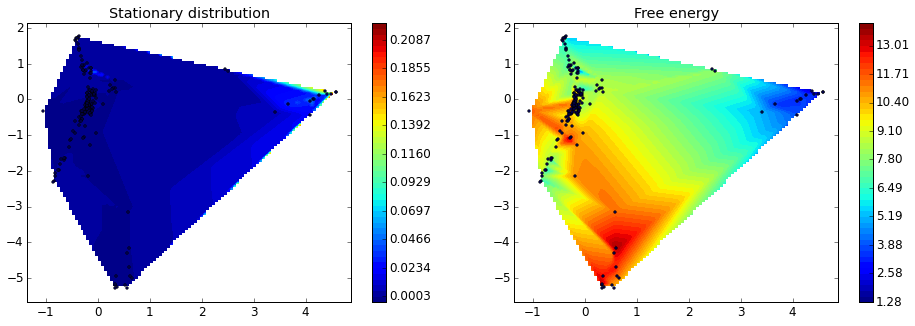

In [92]:
fig = plt.figure(figsize=(16,5))
matplotlib.rcParams.update({'font.size': 12})
ax1=plt.subplot(121)
ax1.set_title('Stationary distribution')
ax1 = mpl.scatter_contour(c_cc_x, c_cc_y, pi)

ax2=plt.subplot(122)
ax2.set_title('Free energy')
ax2 = mpl.scatter_contour(c_cc_x, c_cc_y, F_pi)

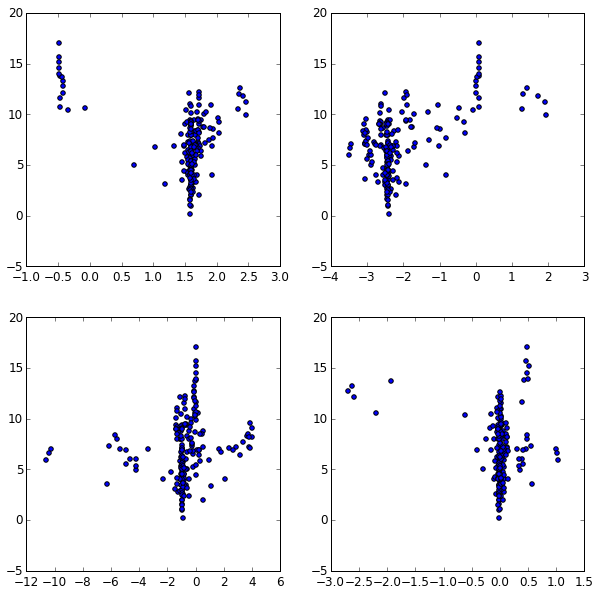

In [93]:
c_distogram = distogram[connected]
N=4
ngrid = int(math.ceil(sqrt(1.0*N)))
figure(figsize=(10,10))
for i in range(N):
    subplot2grid((ngrid,ngrid),(i/ngrid,i%ngrid))
    scatter(M.eigenvectors_right()[:,i+1], c_distogram)
    #semilogy()

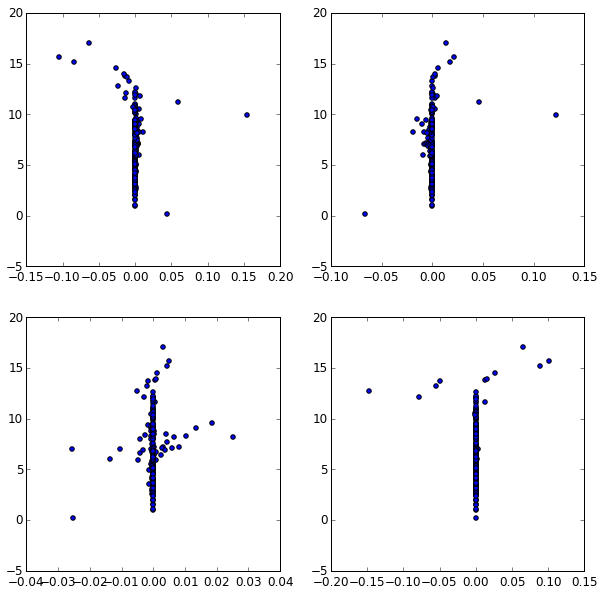

In [94]:
c_distogram = distogram[connected]
N=4
ngrid = int(math.ceil(sqrt(1.0*N)))
figure(figsize=(10,10))
for i in range(N):
    subplot2grid((ngrid,ngrid),(i/ngrid,i%ngrid))
    scatter(M.eigenvectors_left()[i+1], c_distogram)
    #semilogy()

# Free energy and association/dissociation constant as a function of lagtime

In [95]:
tdeltag = []
cnt = 0
lags = [1,2,5,10,15,20,25,30,35,40]
for tau in lags:
    model = msm.bayesian_markov_model(dtrajs, tau)
    mu = model.stationary_distribution
    # distances
    conn = model.connected_sets[0]
    dists = distogram[conn]
    tdeltag.append([])
    for lim in (0.5,1.0,1.5,2.0,3.0):
        pibound = 0
        for i in range(len(mu)):
            if dists[i] > lim:
                pibound += mu[i]
        punb = 1.0 - pibound
        fract = pibound/punb
        deltag = -((numpy.log(fract)*8.314 *298.0)/4148.0)
        tdeltag[cnt].append(deltag)
    #print tau, ['%7.6f' % val for val in tdeltag[cnt]]
    cnt += 1

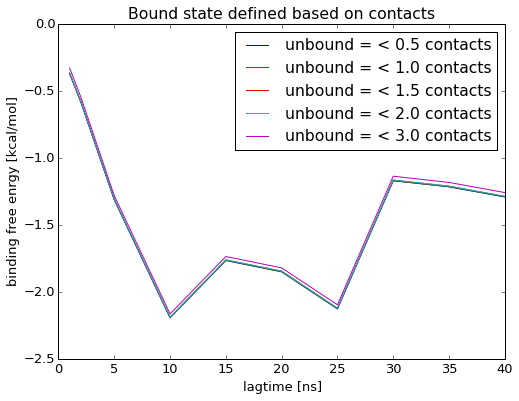

In [96]:
figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 13})
nptdeltag = numpy.array(tdeltag)
plot(lags,nptdeltag[:,0],label='unbound = < 0.5 contacts')
plot(lags,nptdeltag[:,1],label='unbound = < 1.0 contacts')
plot(lags,nptdeltag[:,2],label='unbound = < 1.5 contacts')
plot(lags,nptdeltag[:,3],label='unbound = < 2.0 contacts')
plot(lags,nptdeltag[:,4],label='unbound = < 3.0 contacts')
legend()
xlabel('lagtime [ns]')
ylabel('binding free enrgy [kcal/mol]')
title('Bound state defined based on contacts')
save_figure('contacts-time-deltag.png')

# Association and dissociation constant as a function of lagtime

In [97]:
# define bound and unbound states
blim = 1.0 # number of contacts to belong to bound states
ulim = 1.0 # number of contacts to belong to bound states
bound = []
unbound = []
M = msm.bayesian_markov_model(dtrajs,10)
c_distogram = distogram[M.connected_sets[0]]
for i in range(len(pi)):
    if c_distogram[i] > blim:
        bound.append(i)
    elif c_distogram[i] < ulim:
        unbound.append(i)

In [98]:
# unbound --> bound
umfpt = M.mfpt(unbound,bound)
print 'unbound to bound: ', umfpt
# bound --> unbound
bmfpt = M.mfpt(bound,unbound)
print 'bound to unbound: ', bmfpt
# k_on and k_off
concentration = 0.015 # concentration (Mol)
print 'k_on  experimental = 2.9x10**7 mol-1 sec-1'
print 'k_on: \t\t', (1./(umfpt*concentration))*10**2, '*10**7 mol-1 sec-1' # conversion to Mol-1 sec-1
print 'k_off experimental = 6*10**2 sec-1'
print 'k_off: \t\t', (1./bmfpt)*10**7, '*10**2 sec-1' # conversion to Mol-1 sec-1

unbound to bound:  53.1297163733
bound to unbound:  44283.1989886
k_on  experimental = 2.9x10**7 mol-1 sec-1
k_on: 		125.479056199 *10**7 mol-1 sec-1
k_off experimental = 6*10**2 sec-1
k_off: 		225.819277477 *10**2 sec-1


In [99]:
tbmfpt = []
tumfpt = []
tk_on = []
tk_off = []
cnt = 0
lags = [1,2,5,10,15,20,25,30,35,40]
for tau in lags:
    model = msm.bayesian_markov_model(dtrajs, tau)
    # distances
    conn = model.connected_sets[0]
    dists = distogram[conn]
    bd = []
    ubd = []
    for i in range(len(dists)):
        if dists[i] > blim:
            bd.append(i)
        elif dists[i] < ulim:
            ubd.append(i)
    umf = model.mfpt(ubd,bd)
    bmf = model.mfpt(bd,ubd)
    tbmfpt.append(bmf)
    tumfpt.append(umf)
    tk_on.append((1./(umf*concentration))*10**2)
    tk_off.append((1./(bmf))*10**7)
    #print tau,'\t',umf,'\t',bmf,'\t',(1./(umf*concentration))*10**2,'\t',(1./(bmf))*10**7
    cnt += 1

[]

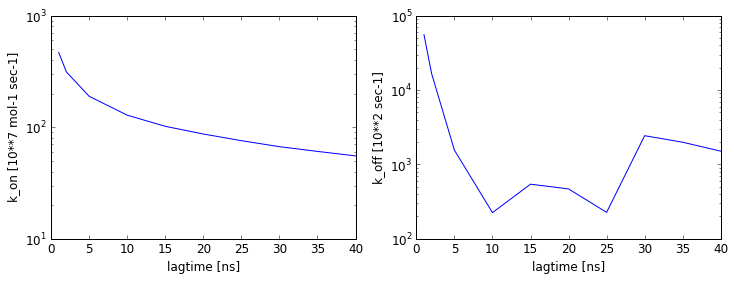

In [102]:
fig = plt.figure(figsize=(12,4))
matplotlib.rcParams.update({'font.size': 12})
ax1=plt.subplot(121)
xlabel('lagtime [ns]')
ylabel('k_on [10**7 mol-1 sec-1]')
ax1 = plot(lags,tk_on)
semilogy()

ax2=plt.subplot(122)
xlabel('lagtime [ns]')
ylabel('k_off [10**2 sec-1]')
ax2 = plot(lags,tk_off)
semilogy()

# PCCA

In [40]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership=M.metastable_memberships  # get PCCA memberships

In [41]:
for i in range(n_sets):
    print np.dot(membership[:,i],pi)

0.0425819285428
0.0298159145651
0.0913248043074
0.836277352585


In [42]:
# average total number of contacts and PCCA_set
c_distogram = distogram[connected]
mnorm = np.arange(len(pi))
for i in range(n_sets):
    mnorm[i] = np.sum(membership[:,i])
for i in range(n_sets):
    print i, np.dot(membership[:,i],c_distogram)/(mnorm[i])

0 6.95081882471
1 8.69143095125
2 7.20020990837
3 10.9393052999


In [43]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

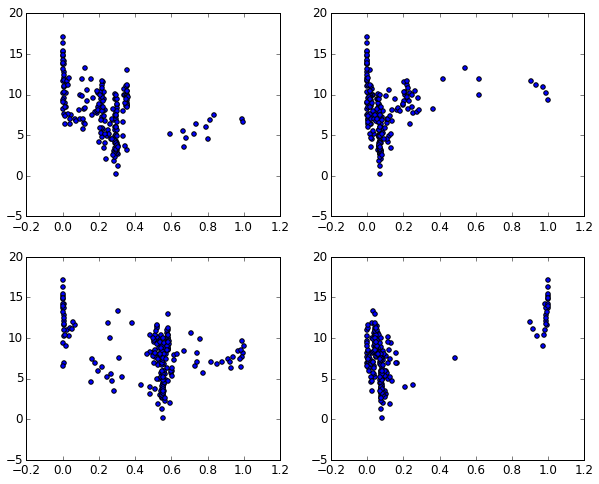

In [44]:
c_distogram = distogram[connected]
fig = plt.figure(figsize=(10,8))

ax1=plt.subplot(221)
ax1 = scatter(membership[:,0],c_distogram)

ax2=plt.subplot(222)
ax1 = scatter(membership[:,1],c_distogram)

ax3=plt.subplot(223)
ax1 = scatter(membership[:,2],c_distogram)

ax4=plt.subplot(224)
ax1 = scatter(membership[:,3],c_distogram)

In [45]:
coor.save_traj(inp, pcca_samples[0], './out_mindists/pcca1_10samples.xtc')
coor.save_traj(inp, pcca_samples[1], './out_mindists/pcca2_10samples.xtc')
coor.save_traj(inp, pcca_samples[2], './out_mindists/pcca3_10samples.xtc')
coor.save_traj(inp, pcca_samples[3], './out_mindists/pcca4_10samples.xtc')

2015-07-28 18:22:07,205 coordinates.api INFO     Created file ./out_mindists/pcca1_10samples.xtc
2015-07-28 18:22:08,731 coordinates.api INFO     Created file ./out_mindists/pcca2_10samples.xtc
2015-07-28 18:22:11,225 coordinates.api INFO     Created file ./out_mindists/pcca3_10samples.xtc
2015-07-28 18:22:12,446 coordinates.api INFO     Created file ./out_mindists/pcca4_10samples.xtc


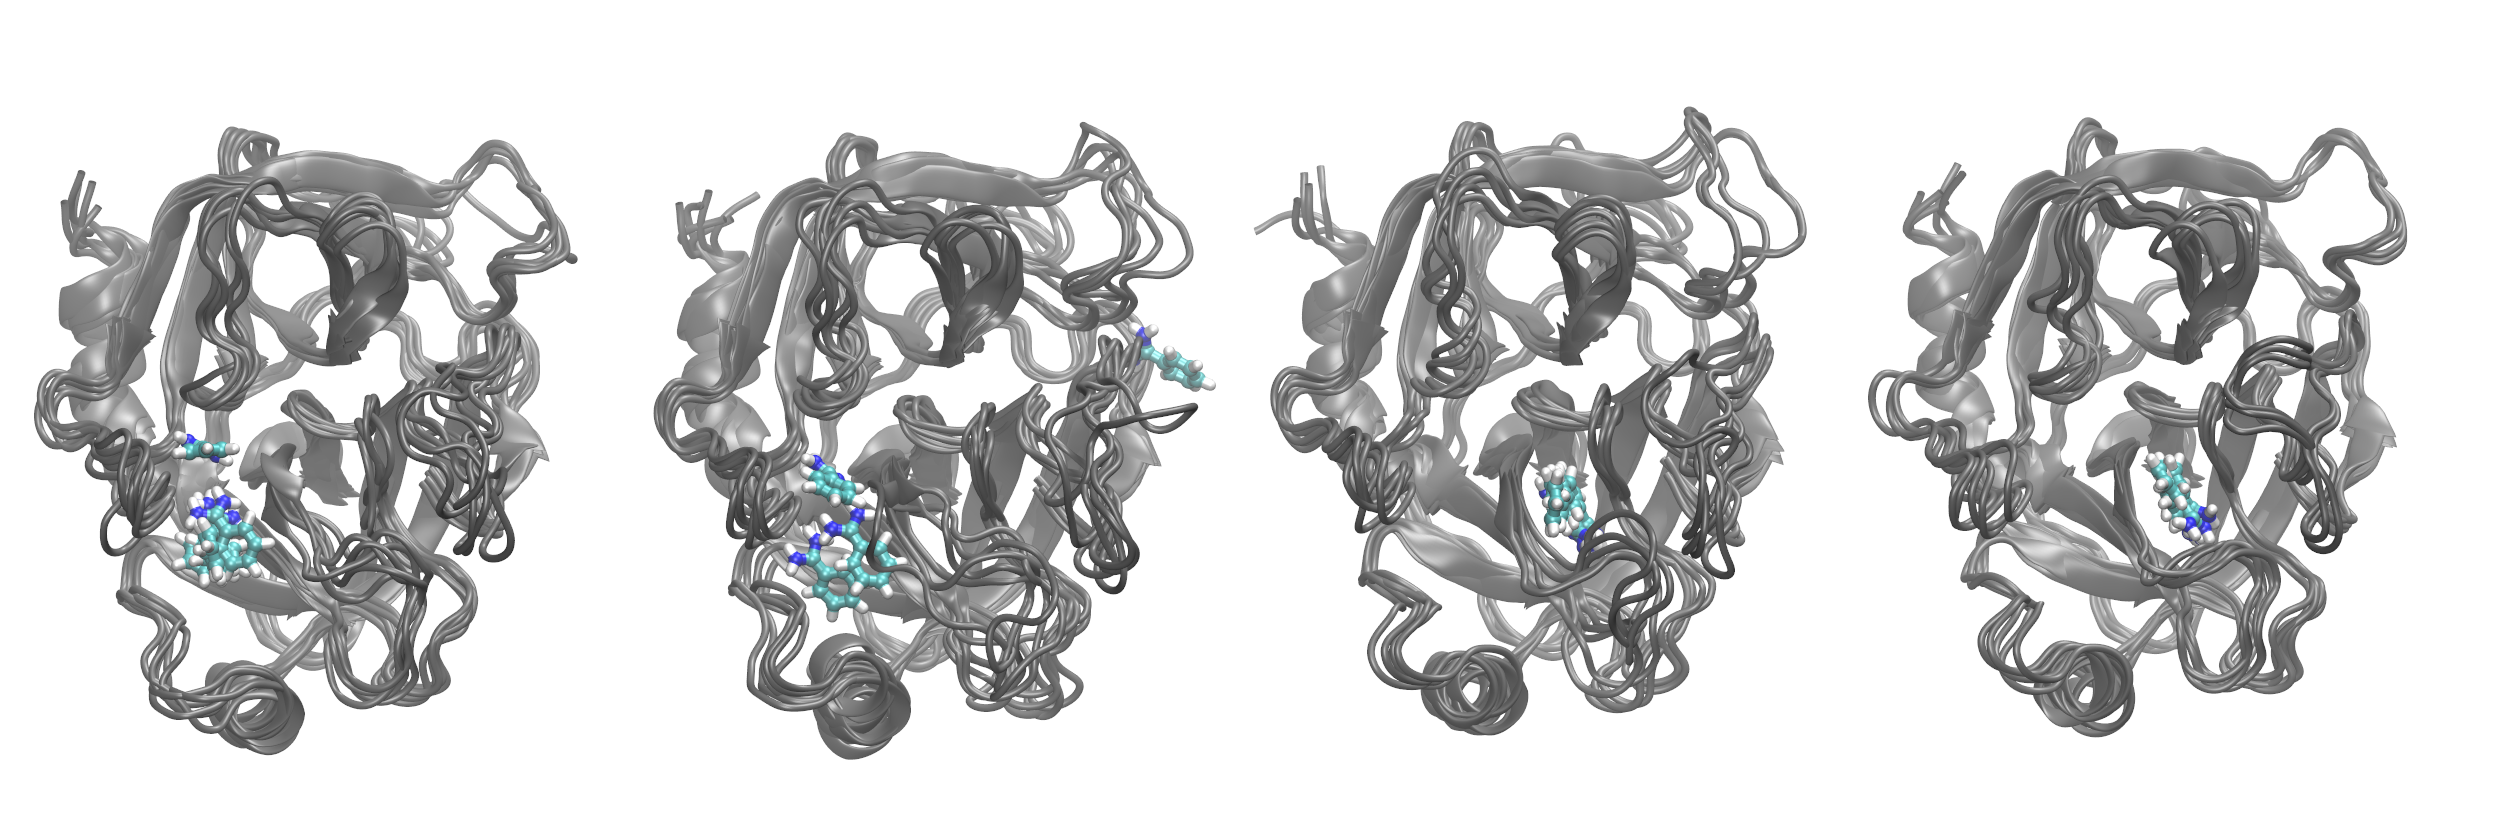

In [46]:
from IPython.display import Image
Image(filename='./out_mindists/con_mindists-pcca.png', width=1000)

# Coarse-grained kinetic Model using a Hidden Markov Model

In [25]:
# save dtrajs for later
np.shape(dtrajs)
np.save('./dtraj/dtrajs.npy', dtrajs)

In [1]:
import msmtools
import pyemma.plots as mplt
from pyemma import msm
from pyemma.util.statistics import confidence_interval
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load dtrajs
dtrajarr = np.load('./dtraj/dtrajs.npy')
dtrajs = [dtrajarr[i, :] for i in range(dtrajarr.shape[0])]

In [4]:
# Maximum-Likelihood estimates
lags=[1,2,3,4,5,6,7]
#its = msm.timescales_hmsm(dtrajs, 5, lags=lags)

In [5]:
its = msm.timescales_hmsm(dtrajs, 5, lags=lags, errors='bayes')

2015-08-04 19:42:32,163 MaximumLikelihoodHMSM[0x106b22750] WARNING  Requested coarse-grained model with 5 metastable states at lag=1.The ratio of relaxation timescales between 5 and 6 states is only 1.63793585103 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
/Users/noe/data/software_projects/msmtools/msmtools/analysis/dense/pcca.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))
2015-08-04 19:42:37,623 MaximumLikelihoodHMSM[0x108d4f2d0] WARNING  Requested coarse-grained model with 5 metastable states at lag=2.The ratio of relaxation timescales between 5 and 6 states is only 1.59593853668 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


my prior: 
[[  1.06585838e+02   1.00584054e-36   6.47244122e-01   3.52755878e-01
    3.16364063e-17]
 [  1.85044416e-36   1.43945486e+02   1.00000000e+00   3.37504226e-24
    1.21791332e-80]
 [  2.35275254e-01   1.97588328e-01   1.42179648e+02   5.18028434e-01
    4.91079840e-02]
 [  1.87085203e-01   9.72965736e-25   7.55806538e-01   6.15997675e+01
    5.71082589e-02]
 [  1.30311021e-16   2.72686435e-80   5.56465156e-01   4.43534844e-01
    5.83149672e+06]]
my prior: 


2015-08-04 19:43:34,061 MaximumLikelihoodHMSM[0x109991e90] WARNING  Requested coarse-grained model with 5 metastable states at lag=3.The ratio of relaxation timescales between 5 and 6 states is only 1.68185688504 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


[[  6.52235359e+01   1.18348733e-09   7.65202832e-01   2.34795098e-01
    2.06894489e-06]
 [  2.65480319e-09   9.69629557e+01   9.14870245e-01   8.51297527e-02
    7.99703535e-15]
 [  3.65991837e-01   1.95067812e-01   1.10467459e+02   3.64907959e-01
    7.40323918e-02]
 [  2.06179915e-01   3.33249865e-02   6.69955313e-01   4.32865366e+01
    9.05397856e-02]
 [  8.02252593e-06   1.38236427e-14   6.00190554e-01   3.99801424e-01
    3.25152827e+05]]
my prior: 


2015-08-04 19:43:53,696 MaximumLikelihoodHMSM[0x109f51510] WARNING  Requested coarse-grained model with 5 metastable states at lag=4.The ratio of relaxation timescales between 5 and 6 states is only 1.44044142441 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


[[  1.07803997e+02   6.93599495e-09   8.29161606e-01   1.70801688e-01
    3.66991730e-05]
 [  1.37159498e-08   6.94778978e+01   8.75959757e-01   1.24040230e-01
    6.31927877e-14]
 [  3.67011055e-01   1.96068126e-01   8.11075877e+01   2.87927041e-01
    1.48993778e-01]
 [  1.90303054e-01   6.98874254e-02   7.24763130e-01   5.82084748e+01
    1.50463904e-02]
 [  1.04809232e-04   9.12627720e-14   9.61327646e-01   3.85675443e-02
    3.81129521e+06]]
my prior: 


2015-08-04 19:44:25,637 MaximumLikelihoodHMSM[0x109f6cb50] WARNING  Requested coarse-grained model with 5 metastable states at lag=5.The ratio of relaxation timescales between 5 and 6 states is only 1.26868431288 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


[[  9.00524044e+01   4.53110425e-09   7.84286279e-01   2.15713711e-01
    5.12842696e-09]
 [  8.12781112e-09   1.34138190e+02   9.99998203e-01   1.78849576e-06
    3.37645656e-11]
 [  3.00113288e-01   2.13324275e-01   8.48959221e+01   3.67376770e-01
    1.19185666e-01]
 [  1.56819080e-01   7.24835608e-07   6.97946665e-01   3.51267280e+01
    1.45233530e-01]
 [  1.00312489e-08   3.68181913e-11   6.09234168e-01   3.90765822e-01
    3.51850204e+05]]
my prior: 


2015-08-04 19:44:42,963 MaximumLikelihoodHMSM[0x10a2271d0] WARNING  Requested coarse-grained model with 5 metastable states at lag=6.The ratio of relaxation timescales between 5 and 6 states is only 1.0258175698 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


[[  1.04120957e+02   9.99859117e-01   2.48319846e-09   1.40879409e-04
    9.94047615e-10]
 [  2.26294840e-01   7.45642944e+01   2.12018125e-01   3.93140575e-01
    1.68546460e-01]
 [  1.74999872e-09   6.60181652e-01   5.17176507e+01   3.39818346e-01
    4.51474352e-11]
 [  6.34728192e-05   7.82622443e-01   2.17250503e-01   4.00419177e+01
    6.35815755e-05]
 [  1.33456921e-09   9.99810535e-01   8.60083660e-11   1.89463227e-04
    8.35186866e+03]]
my prior: 


2015-08-04 19:45:05,964 MaximumLikelihoodHMSM[0x10a243810] WARNING  Requested coarse-grained model with 5 metastable states at lag=7.The ratio of relaxation timescales between 5 and 6 states is only 1.04987523925 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


[[  8.83566686e+01   2.78954528e-08   5.04644363e-06   9.99994925e-01
    2.77980626e-10]
 [  1.80598121e-08   7.54199478e+01   2.90832015e-01   7.09167705e-01
    2.61085801e-07]
 [  2.31485311e-06   2.06063188e-01   3.01309174e+01   6.86101945e-01
    1.07832552e-01]
 [  2.78461119e-01   3.05025331e-01   4.16502303e-01   7.63331802e+01
    1.12465213e-05]
 [  1.18229895e-09   1.71520573e-06   9.99826507e-01   1.71776685e-04
    9.74453706e+03]]
my prior: 
[[  4.35808327e+01   2.24605980e-01   5.83960912e-01   1.91433108e-01
    2.61577814e-84]
 [  7.44271076e-01   2.76092749e+01   2.55728924e-01   9.11343887e-44
    0.00000000e+00]
 [  8.83270655e-01   1.16729345e-01   2.54502545e+01   2.05669944e-16
    7.73953641e-48]
 [  8.33671171e-01   1.19770590e-43   5.92159277e-16   5.86551898e+00
    1.66328829e-01]
 [  6.84874675e-83   0.00000000e+00   1.33972334e-46   1.00000000e+00
    7.99443337e+02]]


NameError: name 'save_figure' is not defined

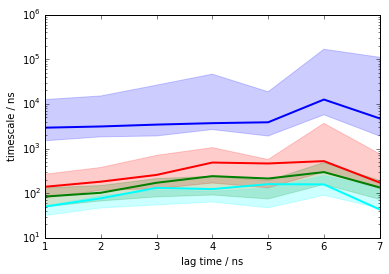

In [6]:
mplt.plot_implied_timescales(its, show_mean=False, units='ns', linewidth=2)
ylim(10, 1000000)
save_figure('its.png')

In [ ]:
Px=np.array{[[  1.07054632e+02,   1.02753523e+00,   2.67896215e-09,   6.40357401e-04,    1.02624879e-09],
             [  4.02772071e+00,   1.32697326e+03,   3.27075838e+00,   7.49825780e+00,    2.99962552e+00],
             [  2.47709626e-09,   1.48432703e+00,   7.69232415e+01,   3.04214127e-03,    2.87369416e-11],
             [  5.59859092e-06,   5.67688698e+00,   2.21754933e+00,   3.16124195e+02,    3.89460413e-04],
             [  1.09402015e-11,   1.12259026e-02,   3.93892615e-11,   1.14653846e-04,    9.47065934e+01]]}

In [8]:
from pyemma.msm import BayesianHMSM

In [9]:
BHMM = BayesianHMSM(nstates=5, lag=1, stride=1, nsamples=100, observe_active=False)
BHMM.estimate(dtrajs)

2015-08-04 02:03:42,379 MaximumLikelihoodHMSM[0x1093547d0] WARNING  Requested coarse-grained model with 5 metastable states at lag=1.The ratio of relaxation timescales between 5 and 6 states is only 1.63793585103 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


my prior: 
[[  1.06585838e+02   1.00584054e-36   6.47244122e-01   3.52755878e-01
    3.16364063e-17]
 [  1.85044416e-36   1.43945486e+02   1.00000000e+00   3.37504226e-24
    1.21791332e-80]
 [  2.35275254e-01   1.97588328e-01   1.42179648e+02   5.18028434e-01
    4.91079840e-02]
 [  1.87085203e-01   9.72965736e-25   7.55806538e-01   6.15997675e+01
    5.71082589e-02]
 [  1.30311021e-16   2.72686435e-80   5.56465156e-01   4.43534844e-01
    5.83149672e+06]]


BayesianHMSM(conf=0.95, connectivity='largest', dt_traj='1 step',
       init_hmsm=None, lag=1, nsamples=100, nstates=5,
       observe_active=False, reversible=True, stride=1)

In [10]:
BHMM.timescales()

array([ 2928.60671574,   138.94892591,    83.93548943,    50.01033013])

In [11]:
BHMM.sample_f('timescales')

[array([ 4196.75978163,   100.48767902,    66.95616868,    40.96046463]),
 array([ 3337.17094049,   166.42118561,    82.30554861,    41.34848027]),
 array([ 5735.61093453,   145.53872291,    54.43444783,    49.01700237]),
 array([ 3663.5753267 ,   147.5608544 ,    66.86768607,    54.65493876]),
 array([ 8507.1292684 ,    85.53512873,    62.48979577,    44.33175906]),
 array([ 8735.5562223 ,    93.07989919,    61.32825916,    38.4738811 ]),
 array([ 4378.38513518,    74.36396901,    52.69178359,    41.17672581]),
 array([ 2607.40424339,    90.07732299,    58.31183338,    40.32544228]),
 array([ 2196.01616508,   119.63855093,    72.63423961,    57.12305278]),
 array([ 1756.5117713 ,   149.04475352,    72.75719523,    42.57010599]),
 array([ 1930.17746103,   197.37019464,    65.00099255,    52.97394065]),
 array([ 1367.46490393,   165.1892786 ,    59.66386986,    41.35551866]),
 array([ 9583.63394706,   150.63029737,    77.93447549,    52.65095369]),
 array([ 5784.66989687,   132.9317089 

In [12]:
BHMM.stationary_distribution

array([  7.59547336e-05,   5.56234065e-05,   2.78082009e-04,
         8.33311309e-05,   9.99507009e-01])

In [13]:
BHMM.sample_f('stationary_distribution')

[array([  1.84488241e-04,   3.00824723e-05,   4.62283556e-04,
          1.70322321e-04,   9.99152823e-01]),
 array([  9.72076456e-05,   3.84856405e-05,   1.85540608e-04,
          6.11647383e-05,   9.99617601e-01]),
 array([  1.11603928e-04,   5.11809671e-04,   1.11296850e-03,
          2.69138431e-04,   9.97994479e-01]),
 array([  7.22166264e-05,   1.00995998e-04,   3.60490034e-04,
          1.14565472e-04,   9.99351732e-01]),
 array([  5.21633203e-05,   3.74468343e-05,   3.31527205e-04,
          8.35989568e-05,   9.99495264e-01]),
 array([  3.83228362e-04,   4.11971753e-04,   1.41570458e-03,
          3.66139021e-04,   9.97422956e-01]),
 array([  4.85783745e-05,   4.75436911e-05,   3.51054983e-04,
          7.14381826e-05,   9.99481385e-01]),
 array([  7.05004427e-05,   3.22387633e-05,   2.10088360e-04,
          6.33970906e-05,   9.99623775e-01]),
 array([  4.29585875e-05,   6.51290935e-05,   3.03805103e-04,
          1.04535220e-04,   9.99483572e-01]),
 array([  1.38707934e-05,   

In [ ]:
# plot timescale distributions
matplotlib.rcParams.update({'font.size': 14})
figure(figsize=(5,4))
colors = ['red', 'green', 'blue', 'cyan']
for ts in range(4):
    # plot MLE
    plot(its.lags, its.timescales[:, ts], linewidth=2, marker='o', color=colors[ts])
    # compute and plot conf
    fill_between(lags, Ls_ts[:, ts], Rs_ts[:, ts], alpha=0.2, color=colors[ts])
semilogy()
xlim(1, 7); xlabel('lag time / ns')
ylim(10, 1000000); ylabel('relaxation time / ns')
save_figure('its.png')

In [24]:
# There's a problem in BHMM with this data set. Will do a bootstrapping for now
def bootstrap(dtrajs):
    I = np.random.choice(len(dtrajs), size=len(dtrajs), replace=True)
    return [dtrajs[i] for i in I]

In [233]:
# do bootstrapping and save results

sample_start = 20
sample_end = 50
for lag in lags:
    print 'lag = ', lag
    for i in range(sample_start, sample_end): 
        hmm = msm.estimate_hidden_markov_model(bootstrap(dtrajs), 5, lag, maxit=100)
        P = np.array(hmm.transition_matrix)
        np.save('./sample_hmm/P_lag'+str(lag)+'_sample'+str(i)+'.npy', P)
        B = np.array(hmm.observation_probabilities)
        np.save('./sample_hmm/B_lag'+str(lag)+'_sample'+str(i)+'.npy', B)
        obs_set = np.array(hmm.observable_set)
        np.save('./sample_hmm/observed_set_lag'+str(lag)+'_sample'+str(i)+'.npy', obs_set)
        del hmm

2015-08-01 15:57:36,841 MaximumLikelihoodHMSM[0x109b070d0] WARNING  Requested coarse-grained model with 5 metastable states at lag=1.The ratio of relaxation timescales between 5 and 6 states is only 1.53759882891 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 15:58:41,768 MaximumLikelihoodHMSM[0x109b07510] WARNING  Requested coarse-grained model with 5 metastable states at lag=1.The ratio of relaxation timescales between 5 and 6 states is only 1.10232595777 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 15:59:50,729 MaximumLikelihoodHMSM[0x109b07410] WARNING  Requested coarse-grained model with 5 metastable states at lag=1.The ratio of relaxation timescales between 5 and 6 states is only 1.26024049672 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 16:01:46,806 MaximumLikelihoodHM

lag =  1
lag = 

2015-08-01 16:30:31,026 MaximumLikelihoodHMSM[0x10993fdd0] WARNING  Requested coarse-grained model with 5 metastable states at lag=2.The ratio of relaxation timescales between 5 and 6 states is only 1.78785948283 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 16:31:06,863 MaximumLikelihoodHMSM[0x109942f50] WARNING  Requested coarse-grained model with 5 metastable states at lag=2.The ratio of relaxation timescales between 5 and 6 states is only 1.51687337026 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 16:31:08,987 MaximumLikelihoodHMSM[0x109942350] WARNING  Requested coarse-grained model with 5 metastable states at lag=2.The ratio of relaxation timescales between 5 and 6 states is only 1.82789330957 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 16:31:17,246 MaximumLikelihoodHM

 2
lag = 

2015-08-01 16:56:55,566 MaximumLikelihoodHMSM[0x109942750] WARNING  Requested coarse-grained model with 5 metastable states at lag=3.The ratio of relaxation timescales between 5 and 6 states is only 1.63801798192 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 16:57:00,873 MaximumLikelihoodHMSM[0x109b07f50] WARNING  Requested coarse-grained model with 5 metastable states at lag=3.The ratio of relaxation timescales between 5 and 6 states is only 1.32741791106 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 16:57:10,500 MaximumLikelihoodHMSM[0x109942090] WARNING  Requested coarse-grained model with 5 metastable states at lag=3.The ratio of relaxation timescales between 5 and 6 states is only 1.01986668311 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 16:57:12,305 MaximumLikelihoodHM

 3
lag = 

2015-08-01 17:09:09,203 MaximumLikelihoodHMSM[0x109942c90] WARNING  Requested coarse-grained model with 5 metastable states at lag=4.The ratio of relaxation timescales between 5 and 6 states is only 1.01564156519 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:09:11,729 MaximumLikelihoodHMSM[0x109f0d710] WARNING  Requested coarse-grained model with 5 metastable states at lag=4.The ratio of relaxation timescales between 5 and 6 states is only 1.29125157613 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:09:15,333 MaximumLikelihoodHMSM[0x109f0db10] WARNING  Requested coarse-grained model with 5 metastable states at lag=4.The ratio of relaxation timescales between 5 and 6 states is only 1.40149839697 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:09:58,881 MaximumLikelihoodHM

 4
lag = 

2015-08-01 17:27:18,326 MaximumLikelihoodHMSM[0x10993f1d0] WARNING  Requested coarse-grained model with 5 metastable states at lag=5.The ratio of relaxation timescales between 5 and 6 states is only 1.40254022694 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:29:08,221 MaximumLikelihoodHMSM[0x10993fcd0] WARNING  Requested coarse-grained model with 5 metastable states at lag=5.The ratio of relaxation timescales between 5 and 6 states is only 1.81792852443 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:29:18,801 MaximumLikelihoodHMSM[0x109f0da90] WARNING  Requested coarse-grained model with 5 metastable states at lag=5.The ratio of relaxation timescales between 5 and 6 states is only 1.69918846243 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:29:21,613 MaximumLikelihoodHM

 5
lag = 

2015-08-01 17:48:13,980 MaximumLikelihoodHMSM[0x109f0db90] WARNING  Requested coarse-grained model with 5 metastable states at lag=6.The ratio of relaxation timescales between 5 and 6 states is only 1.18312953342 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:49:07,813 MaximumLikelihoodHMSM[0x1098cbb50] WARNING  Requested coarse-grained model with 5 metastable states at lag=6.The ratio of relaxation timescales between 5 and 6 states is only 1.94838472504 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:49:14,772 MaximumLikelihoodHMSM[0x109f0d3d0] WARNING  Requested coarse-grained model with 5 metastable states at lag=6.The ratio of relaxation timescales between 5 and 6 states is only 1.43558062494 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 17:49:18,818 MaximumLikelihoodHM

 6
lag = 

2015-08-01 17:59:42,963 MaximumLikelihoodHMSM[0x10a85df10] WARNING  Requested coarse-grained model with 5 metastable states at lag=7.The ratio of relaxation timescales between 5 and 6 states is only 1.89131756029 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 18:00:28,639 MaximumLikelihoodHMSM[0x1098cb1d0] WARNING  Requested coarse-grained model with 5 metastable states at lag=7.The ratio of relaxation timescales between 5 and 6 states is only 1.17542266481 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 18:00:31,738 MaximumLikelihoodHMSM[0x1098cb0d0] WARNING  Requested coarse-grained model with 5 metastable states at lag=7.The ratio of relaxation timescales between 5 and 6 states is only 1.2094479826 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 18:00:45,665 MaximumLikelihoodHMS

 7


In [234]:
# load data from bootstrapping
nsample = 50
Ps = []
Bs = []
obs_sets = []
for lag in lags:
    Ps_lag = []; Bs_lag = []; obs_lag = []
    for i in range(nsample):
        P = np.load('./sample_hmm/P_lag'+str(lag)+'_sample'+str(i)+'.npy')
        pi = msmtools.analysis.stationary_distribution(P)
        B = np.load('./sample_hmm/B_lag'+str(lag)+'_sample'+str(i)+'.npy')
        obs = np.load('./sample_hmm/observed_set_lag'+str(lag)+'_sample'+str(i)+'.npy')
        ts = msmtools.analysis.timescales(P)[1:]
        if ts[0] < 200000 and np.max(pi) < 1.0:  # sanity check, should be replaced by proper Bayes sampling
            Ps_lag.append(P)
            Bs_lag.append(B)
            obs_lag.append(obs)
        #obs_sets.append([np.load('./sample_hmm/observed_set_lag'+str(lag)+'_sample'+str(i)+'.npy') for i in range(nsample)])
    Ps.append(Ps_lag); Bs.append(Bs_lag); obs_sets.append(obs_lag)

In [258]:
# set confidence
conf = 0.8

In [259]:
# compute distributions of timescales:
Ls_ts = []; Rs_ts = []
for l in range(7): # stop when we disconnect
    ts = [msmtools.analysis.timescales(P, tau=lags[l])[1:] for P in Ps[l]]
    ts = np.array(ts)
    L, R = confidence_interval(ts, conf=conf)
    print lags[l], L, R
    Ls_ts.append(L); Rs_ts.append(R)
Ls_ts = np.array(Ls_ts)
Rs_ts = np.array(Rs_ts)

1 [ 1829.7195655    138.59594016    60.25594546    22.74404796] [ 6340.78840553   405.60552672   158.8619363     86.19217795]
2 [ 874.72301461  126.4915896    69.49189795   33.41989698] [ 15662.08138233    821.65110119    228.71348572    100.04929694]
3 [ 328.90456281  146.10723949   86.41414097   34.90602237] [  3.57500864e+05   1.66527802e+03   3.35577768e+02   1.67408134e+02]
4 [ 568.36955487  189.53222617  107.597757     59.41395786] [  3.11878321e+05   2.30540413e+03   4.08449489e+02   1.63831453e+02]
5 [ 1201.18316254   165.99952899    95.11057509    44.49896182] [  4.55282763e+05   1.82625599e+05   1.61557023e+03   1.88737977e+02]
6 [ 1165.80706279   199.60154694   118.96304829    39.58475655] [ 191199.51807632   10857.7461384     1214.57489651     269.27819589]
7 [ 989.63323292  228.9693313   120.7980863    56.41647195] [  7.01992113e+05   5.41574316e+03   5.10950046e+02   2.15932766e+02]


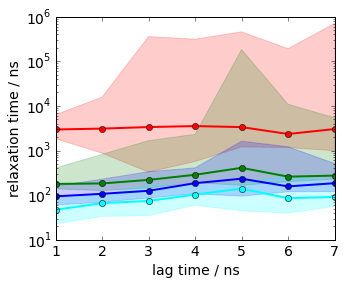

In [260]:
# plot timescale distributions
matplotlib.rcParams.update({'font.size': 14})
figure(figsize=(5,4))
colors = ['red', 'green', 'blue', 'cyan']
for ts in range(4):
    # plot MLE
    plot(its.lags, its.timescales[:, ts], linewidth=2, marker='o', color=colors[ts])
    # compute and plot conf
    fill_between(lags, Ls_ts[:, ts], Rs_ts[:, ts], alpha=0.2, color=colors[ts])
semilogy()
xlim(1, 7); xlabel('lag time / ns')
ylim(10, 1000000); ylabel('relaxation time / ns')
save_figure('its.png')

Trypsin-Benzamidin thermodynamics and kinetics
-----

In [16]:
def index_unbound_bound_bhmm(sampled_hmsm):
    i_bound = np.argmax(sampled_hmsm.stationary_distribution)
    i_unbound = np.argmax(sampled_hmsm.observation_probabilities[:, 0])
    return i_unbound, i_bound

def pi2dG(pi, i_unbound, i_bound):
    delta_g = -0.6 * np.log(pi[i_bound]/pi[i_unbound])  # dG in kcal/mol
    delta_g -= 3.1  # volume correction to standard binding free energy
    return delta_g

def binding_free_energy_bhmm(sampled_hmsm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound_bhmm(sampled_hmsm)
    # MLE
    pi_mle = sampled_hmsm.stationary_distribution
    dG_mle = pi2dG(pi_mle, i_unbound, i_bound)
    # samples
    pi_samples = sampled_hmsm.sample_f('stationary_distribution')
    dG_samples = [pi2dG(pi_sample, i_unbound, i_bound) for pi_sample in pi_samples]
    l, r = confidence_interval(dG_samples, conf=conf)
    return dG_mle, l, r

def mfpt2kon(mfpt):
    mfpt *= 1e-9  # in seconds
    # volume fraction
    Nsim = 10604.0 # number of water molecules in our simulation
    Nstd = 55.55 # number of water molecules in standard volume
    concentration = Nstd / Nsim
    return 1./(mfpt*concentration)

def binding_rate_bhmm(sampled_hmsm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound_bhmm(sampled_hmsm)
    # MLE
    mfpt_mle = sampled_hmsm.mfpt(i_unbound, i_bound)
    kon = mfpt2kon(mfpt_mle)
    # samples
    mfpt_samples = sampled_hmsm.sample_f('mfpt', i_unbound, i_bound)
    kon_samples = [mfpt2kon(mfpt_sample) for mfpt_sample in mfpt_samples]
    l, r = confidence_interval(kon_samples, conf=conf)
    return kon, l, r

def mfpt2koff(mfpt):
    mfpt *= 1e-9  # in seconds
    k_off = 1./mfpt
    return k_off

def unbinding_rate_bhmm(sampled_hmsm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound_bhmm(sampled_hmsm)
    # MLE
    mfpt_mle = sampled_hmsm.mfpt(i_bound, i_unbound)
    koff = mfpt2koff(mfpt_mle)
    # samples
    mfpt_samples = sampled_hmsm.sample_f('mfpt', i_bound, i_unbound)
    koff_samples = [mfpt2koff(mfpt_sample) for mfpt_sample in mfpt_samples]
    l, r = confidence_interval(koff_samples, conf=conf)
    return koff, l, r


In [21]:
dG_stats = np.array([binding_free_energy_bhmm(M) for M in its.models])
kon_stats = np.array([binding_rate_bhmm(M) for M in its.models])
koff_stats = np.array([unbinding_rate_bhmm(M) for M in its.models])

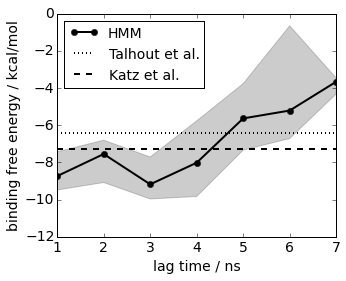

In [25]:
matplotlib.rcParams.update({'font.size': 14})
figure(figsize=(5,4))
# plot binding affinities
plot(its.lags, dG_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, dG_stats[:, 1], dG_stats[:, 2], alpha=0.2, color='black')
# experimental reference:  6.2 kcal from Mares-Guia, M. & Shaw, E. Studies on the active center of trypsin: the binding of amidines and guanidines as a model of the substrate sidechain. J. Biol. Chem. 240, 1579–1585 (1965)
# plot(its.lags, 6.2*np.ones(len(its.lags)), linewidth=2, linestyle='dotted', color='black')
# experimental reference: 6.4 kcal/mold from Talhout R, Engberts JBFN. Eur J Biochem. 2001;268(6):1554–1560
plot(its.lags, -6.4*np.ones(len(its.lags)), linewidth=2, linestyle='dotted', color='black', label='Talhout et al.')
# experimental reference: 7.3 kcal/mold from 66. Katz BA, Elrod K, Luong C, Rice MJ, Mackman RL, Sprengeler PA, Spencer J, Hataye J, Janc J, Link J, Litvak J, Rai R, Rice K, Sideris S, Verner E, Young W. Journal of Molecular Biology. 2001;307(5):1451–1486.
plot(its.lags, -7.3*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Katz et al.')
xlim(1, 7); xlabel('lag time / ns')
ylim(-12, 0); ylabel('binding free energy / kcal/mol')
legend(loc=2, fontsize=14)
save_figure('dG.png')

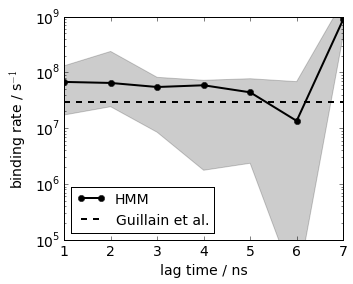

In [26]:
# experimental values from Guillain, F. & Thusius, D. Use of proflavine as an indicator in temperature- jump studies of the binding of a competitive inhibitor to trypsin. J. Am. Chem. Soc. 92, 5534–5536 (1970).
matplotlib.rcParams.update({'font.size': 14})
figure(figsize(5,4))
# plot binding rates
plot(lags, kon_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, kon_stats[:, 1], kon_stats[:, 2], alpha=0.2, color='black')
# experimental
# print 'k_on  experimental = 2.9x10**7 mol-1 sec-1'
plot(its.lags, 2.9*1e7*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Guillain et al.')
legend(loc=3, fontsize=14)
xlim(1, 7); xlabel('lag time / ns')
ylim(1e5, 1e9); ylabel('binding rate / s$^{-1}$')
semilogy()
save_figure('k_on.png')

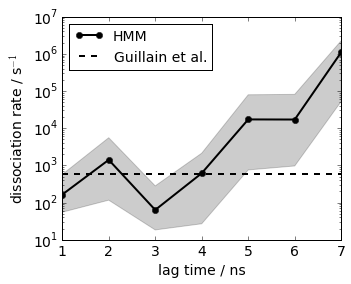

In [35]:
matplotlib.rcParams.update({'font.size': 14})
figure(figsize(5,4))
# plot binding rates
plot(lags, koff_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, koff_stats[:, 1], koff_stats[:, 2], alpha=0.2, color='black')
# experimental
#print 'k_off experimental = 6*10**2 sec-1'
plot(its.lags, 600.0*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Guillain et al.')
xlim(1, 7); xlabel('lag time / ns')
ylim(1e1, 1e7); ylabel('dissociation rate / s$^{-1}$')
legend(loc=2, fontsize=14)
semilogy()
save_figure('k_off.png')

Bootstrapping
------------

In [14]:
def index_unbound_bound(P, B):
    # bound state
    pi = msmtools.analysis.statdist(P)
    #print pi
    i_bound = np.argmax(pi)
    # unbound state
    i_unbound = np.argmax(B[:, 0])
    #mem = (np.dot(np.diag(pi), B)).T
    #mem /= mem.sum(axis=1)[:, None]
    #print mem[0]
    #i_unbound = np.argmax(mem[0])
    return i_unbound, i_bound
    
def binding_free_energy(P, B, lag):
    i_unbound, i_bound = index_unbound_bound(P, B)
    if i_unbound == i_bound:
        return None  # fail
    pi = msmtools.analysis.statdist(P)
    delta_g = -0.6 * np.log(pi[i_bound]/pi[i_unbound])  # dG in kcal/mol
    delta_g -= 3.1  # volume correction to standard binding free energy
    return delta_g    

def binding_rate(P, B, lag):
    i_unbound, i_bound = index_unbound_bound(P, B)
    if i_unbound == i_bound:
        return None  # fail
    t_on = lag*msmtools.analysis.mfpt(P, i_bound, origin=i_unbound)  # in nanoseconds
    t_on *= 1e-9  # in seconds
    # volume fraction
    Nsim = 10604.0 # number of water molecules in our simulation
    Nstd = 55.55 # number of water molecules in standard volume
    concentration = Nstd / Nsim
    k_on = 1./(t_on*concentration)
    return k_on

def unbinding_rate(P, B, lag):
    i_unbound, i_bound = index_unbound_bound(P, B)
    if i_unbound == i_bound:
        return None  # fail
    t_off = lag*msmtools.analysis.mfpt(P, i_unbound, origin=i_bound)  # in nanoseconds
    t_off *= 1e-9  # in seconds
    k_off = 1./t_off
    return k_off

In [15]:
dGs_mle = [binding_free_energy(M.transition_matrix, M.observation_probabilities, M.lag) for M in its.models]
kons_mle = [binding_rate(M.transition_matrix, M.observation_probabilities, M.lag) for M in its.models]
koffs_mle = [unbinding_rate(M.transition_matrix, M.observation_probabilities, M.lag) for M in its.models]

In [263]:
# compute distributions of timescales:
Ls_dG = []; Rs_dG = []
Ls_kon = []; Rs_kon = []
Ls_koff = []; Rs_koff = []
for l in range(7): # stop when we disconnect
    dGs = []; kons=[]; koffs=[]
    for i in range(len(Ps[l])):        
        dG = binding_free_energy(Ps[l][i], Bs[l][i], lags[l])
        kon = binding_rate(Ps[l][i], Bs[l][i], lags[l])
        koff = unbinding_rate(Ps[l][i], Bs[l][i], lags[l])
        if dG is not None:
            dGs.append(dG); kons.append(kon); koffs.append(koff)
    L_dG, R_dG = confidence_interval(dGs, conf=conf)
    Ls_dG.append(L_dG); Rs_dG.append(R_dG)
    L_kon, R_kon = confidence_interval(kons, conf=conf)
    Ls_kon.append(L_kon); Rs_kon.append(R_kon)
    L_koff, R_koff = confidence_interval(koffs, conf=conf)
    Ls_koff.append(L_koff); Rs_koff.append(R_koff)
Ls_dG = np.array(Ls_dG); Rs_dG = np.array(Rs_dG)
Ls_kon = np.array(Ls_kon); Rs_kon = np.array(Rs_kon)
Ls_koff = np.array(Ls_koff); Rs_koff = np.array(Rs_koff)

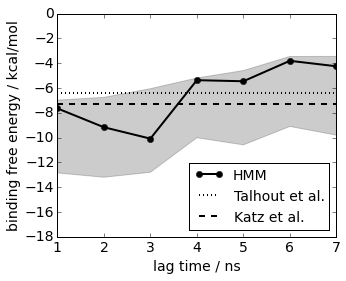

In [264]:
matplotlib.rcParams.update({'font.size': 14})
figure(figsize=(5,4))
# plot binding affinities
plot(its.lags, dGs_mle, linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, Ls_dG, Rs_dG, alpha=0.2, color='black')
# experimental reference:  6.2 kcal from Mares-Guia, M. & Shaw, E. Studies on the active center of trypsin: the binding of amidines and guanidines as a model of the substrate sidechain. J. Biol. Chem. 240, 1579–1585 (1965)
# plot(its.lags, 6.2*np.ones(len(its.lags)), linewidth=2, linestyle='dotted', color='black')
# experimental reference: 6.4 kcal/mold from Talhout R, Engberts JBFN. Eur J Biochem. 2001;268(6):1554–1560
plot(its.lags, -6.4*np.ones(len(its.lags)), linewidth=2, linestyle='dotted', color='black', label='Talhout et al.')
# experimental reference: 7.3 kcal/mold from 66. Katz BA, Elrod K, Luong C, Rice MJ, Mackman RL, Sprengeler PA, Spencer J, Hataye J, Janc J, Link J, Litvak J, Rai R, Rice K, Sideris S, Verner E, Young W. Journal of Molecular Biology. 2001;307(5):1451–1486.
plot(its.lags, -7.3*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Katz et al.')
xlim(1, 7); xlabel('lag time / ns')
ylim(-18, 0); ylabel('binding free energy / kcal/mol')
legend(loc=4, fontsize=14)
save_figure('dG.png')

In [ ]:
for M in its.models:
    i_unbound, i_bound = index_unbound_bound(M.transition_matrix, M.observation_probabilities)
    M.sample_conf()

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
figure(figsize=(5,4))
# plot binding affinities
plot(its.lags, dGs_mle, linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
for M
Ls_dG, 
Rs_dg = 
fill_between(lags, Ls_dG, Rs_dG, alpha=0.2, color='black')
# experimental reference:  6.2 kcal from Mares-Guia, M. & Shaw, E. Studies on the active center of trypsin: the binding of amidines and guanidines as a model of the substrate sidechain. J. Biol. Chem. 240, 1579–1585 (1965)
# plot(its.lags, 6.2*np.ones(len(its.lags)), linewidth=2, linestyle='dotted', color='black')
# experimental reference: 6.4 kcal/mold from Talhout R, Engberts JBFN. Eur J Biochem. 2001;268(6):1554–1560
plot(its.lags, -6.4*np.ones(len(its.lags)), linewidth=2, linestyle='dotted', color='black', label='Talhout et al.')
# experimental reference: 7.3 kcal/mold from 66. Katz BA, Elrod K, Luong C, Rice MJ, Mackman RL, Sprengeler PA, Spencer J, Hataye J, Janc J, Link J, Litvak J, Rai R, Rice K, Sideris S, Verner E, Young W. Journal of Molecular Biology. 2001;307(5):1451–1486.
plot(its.lags, -7.3*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Katz et al.')
xlim(1, 7); xlabel('lag time / ns')
ylim(-18, 0); ylabel('binding free energy / kcal/mol')
legend(loc=4, fontsize=14)
save_figure('dG.png')

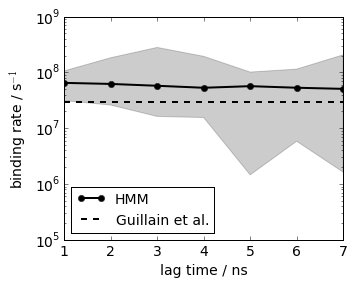

In [265]:
# experimental values from Guillain, F. & Thusius, D. Use of proflavine as an indicator in temperature- jump studies of the binding of a competitive inhibitor to trypsin. J. Am. Chem. Soc. 92, 5534–5536 (1970).
matplotlib.rcParams.update({'font.size': 14})
figure(figsize(5,4))
# plot binding rates
plot(lags, kons_mle, linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, Ls_kon, Rs_kon, alpha=0.2, color='black')
# experimental
# print 'k_on  experimental = 2.9x10**7 mol-1 sec-1'
plot(its.lags, 2.9*1e7*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Guillain et al.')
legend(loc=3, fontsize=14)
xlim(1, 7); xlabel('lag time / ns')
ylim(1e5, 1e9); ylabel('binding rate / s$^{-1}$')
semilogy()
save_figure('k_on.png')

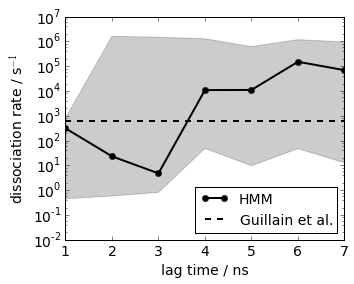

In [266]:
matplotlib.rcParams.update({'font.size': 14})
figure(figsize(5,4))
# plot binding rates
plot(lags, koffs_mle, linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, Ls_koff, Rs_koff, alpha=0.2, color='black')
# experimental
#print 'k_off experimental = 6*10**2 sec-1'
plot(its.lags, 600.0*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Guillain et al.')
xlim(1, 7); xlabel('lag time / ns')
ylim(1e-2, 1e7); ylabel('dissociation rate / s$^{-1}$')
legend(loc=4, fontsize=14)
semilogy()
save_figure('k_off.png')

In [256]:
# Bayesian estimate for lag 1
bhmm = msm.bayesian_hidden_markov_model(dtrajs, 5, 1)

2015-08-01 18:17:58,180 MaximumLikelihoodHMSM[0x10a182150] WARNING  Requested coarse-grained model with 5 metastable states at lag=1.The ratio of relaxation timescales between 5 and 6 states is only 1.16616931536 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [257]:
# validate
ck = bhmm.cktest(mlags=7)

2015-08-01 18:18:13,197 MaximumLikelihoodHMSM[0x10856be90] WARNING  Requested coarse-grained model with 5 metastable states at lag=1.The ratio of relaxation timescales between 5 and 6 states is only 1.16616931536 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
2015-08-01 18:18:27,095 MaximumLikelihoodHMSM[0x109e8d590] WARNING  Requested coarse-grained model with 5 metastable states at lag=2.The ratio of relaxation timescales between 5 and 6 states is only 1.28106026304 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


KeyboardInterrupt: 

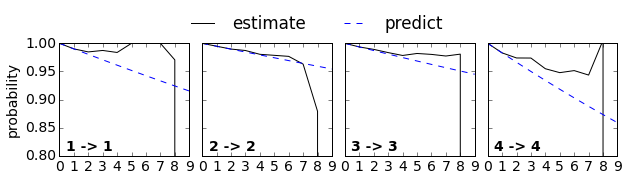

In [290]:
fig, axes = mpl.plot_cktest(ck, diag=True, padding_top=0.25)
for i in range(4):
    axes[i].set_ylim(0.8, 1.0)

In [36]:
hmm = its.models[0]

In [39]:
pos=np.array([[1.75,0],[0,1],[3,3],[4.25,0],[6,1.0]])
state_colors = ['cyan', 'yellow', 'green', 'blue', 'purple']
state_sizes = hmm.stationary_distribution**(0.25)
print state_sizes

[ 0.09335524  0.08636035  0.12913478  0.09554365  0.99987673]


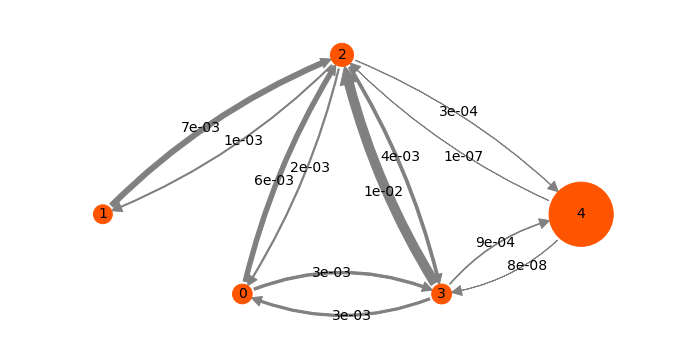

In [42]:
fig, pos = mplt.plot_markov_model(hmm, pos=pos, state_sizes=state_sizes, minflux=1e-9)
gca().set_frame_on(False)
save_figure('network.png')

In [38]:
hmm.transition_matrix

array([[  9.90705096e-01,   9.34919090e-39,   6.01607175e-03,
          3.27883189e-03,   2.94057348e-19],
       [  1.27664835e-38,   9.93100854e-01,   6.89914551e-03,
          2.32849076e-26,   8.40256119e-83],
       [  1.64321715e-03,   1.38000289e-03,   9.93015767e-01,
          3.61803120e-03,   3.42981594e-04],
       [  2.98859262e-03,   1.55426414e-26,   1.20736317e-02,
          9.84025500e-01,   9.12275895e-04],
       [  2.23460640e-23,   4.67609606e-87,   9.54240544e-08,
          7.60584786e-08,   9.99999829e-01]])

In [37]:
# Error bars
hmm.sample_conf('transition_matrix')

(array([[  9.82235563e-01,   6.19072781e-41,   2.47992021e-03,
           1.28901724e-03,   4.95238533e-21],
        [  6.49258411e-41,   9.86029081e-01,   2.60938253e-03,
           6.99223908e-29,   1.26603628e-84],
        [  8.61985186e-04,   7.34444203e-04,   9.90301713e-01,
           2.16927872e-03,   5.32219641e-05],
        [  1.52433400e-03,   8.11266040e-29,   8.15011825e-03,
           9.77907656e-01,   2.39212216e-04],
        [  2.66036546e-25,   6.12470346e-89,   1.90857825e-08,
           1.51764246e-08,   9.99999462e-01]]),
 array([[  9.95512455e-01,   7.86882989e-37,   1.27703489e-02,
           7.65970834e-03,   6.51523755e-17],
        [  9.81556912e-37,   9.97391213e-01,   1.39996382e-02,
           1.03604443e-24,   1.89297241e-80],
        [  3.46238758e-03,   3.15735890e-03,   9.94578726e-01,
           5.23405082e-03,   6.65523817e-04],
        [  6.00092647e-03,   5.26964344e-25,   1.70789666e-02,
           9.88596263e-01,   2.65238983e-03],
        [  2.0394

In [43]:
tpt = msm.tpt(hmm, [2], [4])

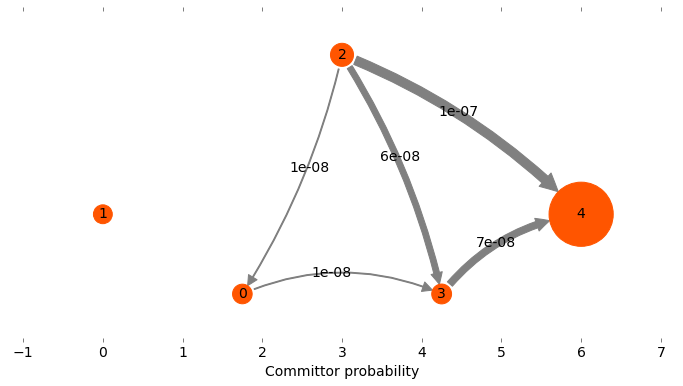

In [45]:
mplt.plot_flux(tpt, state_sizes=state_sizes, pos=pos)
gca().set_frame_on(False)
save_figure('network_flux.png')

In [ ]:
c_distogram

In [209]:
for i in range(5):
    memi = hmm.metastable_memberships[:, i]
    print i, np.where(memi >= 0.95)[0]

0 [  8   9  15  17  22  25  26  27  28  32  55  61  67  89  91 108 111 120
 126 127 130 132 147 149 157 168 179 183 186 191]
1 [  1   6  16  49  69  77 102 119 121 125 128 137 144 156 161 178]
2 [  0   5  10  12  13  14  19  21  24  29  30  33  35  36  37  41  42  44
  45  46  47  48  51  53  54  56  57  58  59  60  64  65  66  68  75  76
  78  79  80  81  82  83  84  85  88  93  94  95  99 100 103 105 107 109
 110 112 115 117 123 124 129 133 134 138 139 140 141 145 146 148 151 152
 153 154 155 158 163 164 166 167 171 172 173 174 175 176 177 180 181 184
 187 188 189 190 193 194 197 199]
3 [  2  11  23  31  34  62  63  72  73  74  98 114 116 122 131 136 169 192]
4 [  3   4  18  20  40  43  52  71  86  92 106 142 162 170 182 195 196]


In [211]:
hmm.metastable_distributions[2]

array([  7.71392441e-001,   8.60798463e-031,   1.22920039e-138,
         4.71482056e-249,   2.44069084e-217,   8.56450895e-004,
         5.92002575e-011,   2.45348645e-102,   3.57155933e-004,
         7.45117918e-100,   1.71290179e-003,   2.92929558e-041,
         5.99515626e-003,   2.39806251e-003,   8.73579913e-003,
         1.37262125e-097,   2.43287968e-137,   2.13141851e-106,
         1.72189481e-004,   2.91193304e-003,   1.42769803e-206,
         1.71290179e-004,   4.17495479e-104,   2.68705144e-117,
         6.50902680e-003,   3.41179645e-004,   5.30930781e-072,
         2.15609354e-087,   1.57977265e-064,   2.91193304e-003,
         9.42095984e-003,   9.80442488e-067,   5.58838307e-046,
         1.71290179e-004,   7.85922433e-141,   5.13870537e-004,
         1.71290179e-004,   6.85160716e-004,   1.57159518e-024,
         3.12520575e-086,   5.50454969e-102,   3.42580358e-004,
         1.02774107e-003,   5.27468485e-251,   8.90915530e-003,
         2.56935268e-003,   4.11096430e-

In [212]:
meta_samples = hmm.sample_by_observation_probabilities(100)

In [214]:
outfiles = ['./out_mindists/hmm1_100samples.xtc', 
            './out_mindists/hmm2_100samples.xtc', 
            './out_mindists/hmm3_100samples.xtc', 
            './out_mindists/hmm4_100samples.xtc', 
            './out_mindists/hmm5_100samples.xtc']

In [215]:
coor.save_trajs(inp, meta_samples, outfiles=outfiles)

2015-07-31 17:29:54,057 coordinates.api INFO     Created file ./out_mindists/hmm1_100samples.xtc
2015-07-31 17:30:04,260 coordinates.api INFO     Created file ./out_mindists/hmm2_100samples.xtc
2015-07-31 17:30:21,772 coordinates.api INFO     Created file ./out_mindists/hmm3_100samples.xtc
2015-07-31 17:30:34,393 coordinates.api INFO     Created file ./out_mindists/hmm4_100samples.xtc
2015-07-31 17:30:44,086 coordinates.api INFO     Created file ./out_mindists/hmm5_100samples.xtc


['./out_mindists/hmm1_100samples.xtc',
 './out_mindists/hmm2_100samples.xtc',
 './out_mindists/hmm3_100samples.xtc',
 './out_mindists/hmm4_100samples.xtc',
 './out_mindists/hmm5_100samples.xtc']